### 1. Getting the data and uploading it into our google drive.


In [ ]:
# # Mounting the google drive(Of Pheonix Squadron)

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/kaggle.json

!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d andrewmvd/retinal-disease-classification

100% 7.41G/7.43G [01:03<00:00, 242MB/s]
100% 7.43G/7.43G [01:05<00:00, 122MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/retinal-disease-classification.zip','r') as zip_ref:
  zip_ref.extractall('Diabetic Retinopathy')

In [ ]:
import os
os.remove('/content/retinal-disease-classification.zip')

### 2. Setting the Paths.

In [ ]:
import os

In [ ]:
Data_path = '/content/Diabetic Retinopathy'

In [ ]:
Training_set = os.path.join(Data_path,'Training_Set','Training_Set')
Testing_set = os.path.join(Data_path,'Test_Set','Test_Set')
Validation_set = os.path.join(Data_path,'Evaluation_Set','Evaluation_Set')

In [ ]:
Training_set

'/content/Diabetic Retinopathy/Training_Set/Training_Set'

In [ ]:
Testing_set

'/content/Diabetic Retinopathy/Test_Set/Test_Set'

In [ ]:
Validation_set

'/content/Diabetic Retinopathy/Evaluation_Set/Evaluation_Set'

In [ ]:
Training_images = os.path.join(Training_set,'Training/')
Testing_images = os.path.join(Testing_set,'Test/')
Validation_images = os.path.join(Validation_set,'Validation/')

In [ ]:
Training_images

'/content/Diabetic Retinopathy/Training_Set/Training_Set/Training/'

In [ ]:
Testing_images

'/content/Diabetic Retinopathy/Test_Set/Test_Set/Test/'

In [ ]:
Validation_images

'/content/Diabetic Retinopathy/Evaluation_Set/Evaluation_Set/Validation/'

In [ ]:
Training_labels = os.path.join(Training_set,'RFMiD_Training_Labels.csv')
Testing_labels = os.path.join(Testing_set,'RFMiD_Testing_Labels.csv')
Validation_labels = os.path.join(Validation_set,'RFMiD_Validation_Labels.csv')

In [ ]:
Training_labels

'/content/Diabetic Retinopathy/Training_Set/Training_Set/RFMiD_Training_Labels.csv'

In [ ]:
Testing_labels

'/content/Diabetic Retinopathy/Test_Set/Test_Set/RFMiD_Testing_Labels.csv'

In [ ]:
Validation_labels

'/content/Diabetic Retinopathy/Evaluation_Set/Evaluation_Set/RFMiD_Validation_Labels.csv'

### 3. Importing the necessary modules and reading the labels: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import cv2
import random
import tensorflow as tf

from tensorflow import keras
from google.colab import files
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.layers.convolutional import Conv2D
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score, classification_report

In [ ]:
Train_df = pd.read_csv(Training_labels)
Test_df = pd.read_csv(Testing_labels)
Val_df = pd.read_csv(Validation_labels)

### 4. Basic EDA

In [ ]:
Train_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Test_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Val_df.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,CME,PTCR,CF,VH,MCA,VS,BRAO,PLQ,HPED,CL
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Train_df.drop(columns=Train_df.columns[3:],axis=1,inplace=True)
Test_df.drop(columns=Test_df.columns[3:],axis=1,inplace=True)
Val_df.drop(columns=Val_df.columns[3:],axis=1,inplace=True)

In [ ]:
Train_df.drop(columns=['Disease_Risk'],axis=1,inplace=True)
Test_df.drop(columns=['Disease_Risk'],axis=1,inplace=True)
Val_df.drop(columns=['Disease_Risk'],axis=1,inplace=True)

In [ ]:
Train_df.head()

,ID,DR
0,1,1
1,2,1
2,3,1
3,4,0
4,5,1


In [ ]:
Test_df.head()

,ID,DR
0,1,1
1,2,1
2,3,1
3,4,0
4,5,0


In [ ]:
Val_df.head()

,ID,DR
0,1,1
1,2,0
2,3,0
3,4,0
4,5,0


In [ ]:
Train_df.describe()

,ID,DR
count,1920.000000,1920.000000
mean,960.500000,0.195833
std,554.400577,0.396944
min,1.000000,0.000000
25%,480.750000,0.000000
50%,960.500000,0.000000
75%,1440.250000,0.000000
max,1920.000000,1.000000


In [ ]:
Val_df.describe()

,ID,DR
count,640.000000,640.000000
mean,320.500000,0.206250
std,184.896367,0.404929
min,1.000000,0.000000
25%,160.750000,0.000000
50%,320.500000,0.000000
75%,480.250000,0.000000
max,640.000000,1.000000


In [ ]:
Train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1920 entries, 0 to 1919
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      1920 non-null   int64
 1   DR      1920 non-null   int64
dtypes: int64(2)
memory usage: 30.1 KB


In [ ]:
Val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   ID      640 non-null    int64
 1   DR      640 non-null    int64
dtypes: int64(2)
memory usage: 10.1 KB


In [ ]:
Train_df.isna().sum()

ID    0
DR    0
dtype: int64

In [ ]:
Val_df.isna().sum()

ID    0
DR    0
dtype: int64

### 5. Getting the file paths for the images.

In [ ]:
Train_df['filepath'] = Train_df['ID'].apply(lambda x: Training_images + str(x) + '.png')
Val_df['filepath'] = Val_df['ID'].apply(lambda x: Validation_images + str(x) + '.png')
Test_df['filepath'] = Test_df['ID'].apply(lambda x: Testing_images + str(x) + '.png')

In [ ]:
Train_df['filepath'][0]

'/content/Diabetic Retinopathy/Training_Set/Training_Set/Training/1.png'

In [ ]:
Val_df['filepath'][0]

'/content/Diabetic Retinopathy/Evaluation_Set/Evaluation_Set/Validation/1.png'

In [ ]:
Test_df['filepath'][0]

'/content/Diabetic Retinopathy/Test_Set/Test_Set/Test/1.png'

### 6. Sample Images

In [ ]:
Train_df['DR'].value_counts()

0    1544
1     376
Name: DR, dtype: int64

In [ ]:
Val_df['DR'].value_counts()

0    508
1    132
Name: DR, dtype: int64

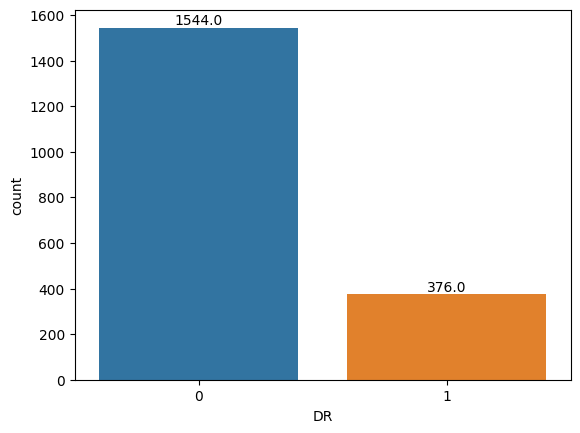

In [ ]:
ax = sns.countplot(x='DR',data=Train_df)
for p in ax.patches:
  ax.annotate(f'{p.get_height()}',(p.get_x()+p.get_width()/2.,p.get_height()),ha='center',va='bottom')

plt.show()

Display Random Images


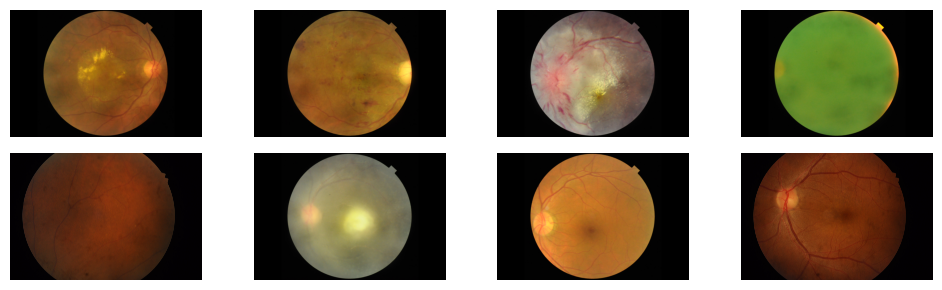

In [ ]:
# Getting random eye images from the Train Image paths
random_eye_images = [np.random.choice(Train_df['filepath']) for i in range(8)]

print("Display Random Images")

# Setting the figure size to 20px horizontally and 10px vertically.
plt.figure(figsize=(10, 3))

# Plotting 9 random images of the eyes.
for i in range(8):
  plt.subplot(2, 4, i+1)                # plt.subplot(nrows, ncols, index) nrows: no.of rows, ncols: no.of cols, index: selecting the subplot.
  img = plt.imread(random_eye_images[i])  # Reading the image using plt.imread function.
  plt.imshow(img)                         # Showing the images by plotting them.
  plt.axis('off')                         # Not taking the axis.
  
plt.tight_layout()                        # Used to adjust padding between the subplots.

### 7. Generating Train Images for the model

In [ ]:
# Concatenating Train and Validation Data for more training examples.

train_Data = pd.concat([Train_df, Val_df])

In [ ]:
# Out of 2500+ images, 508 images have Diabetic Retinopathy

train_Data['DR'].value_counts()

0    2052
1     508
Name: DR, dtype: int64

In [ ]:
# Defining a function that returns a dataframe with 40% 'DR' and 60% 'NO DR' labelled images 

def balance_Data(data, feature):
  class_01 = data[data[feature] == 1]
  class_00 = data[data[feature] == 0]
  return shuffle(pd.concat([class_01, class_00.sample(n = round(1.5 * len(class_01)))]))

In [ ]:
# Getting our new Train Dataframe

bal_Train_Data = balance_Data(train_Data, 'DR')

In [ ]:
# Number of images in our Train Data

bal_Train_Data['DR'].value_counts()

0    762
1    508
Name: DR, dtype: int64

### 8. Preprocessing of Images

In [ ]:
# Load and preprocess the Images

from PIL import Image

def img2Gray(image_Paths):
  gray_Images = []

  for image_Path in image_Paths:
      gray_Image = Image.open(image_Path).resize((224, 224))
      gray_Array = np.array(gray_Image)
      norm_Array = gray_Array / 255.0
      reshaped_Array = norm_Array.reshape(224, 224, 3)
      gray_Images.append(reshaped_Array)
      
  gray_Images = np.array(gray_Images)
  return gray_Images

In [ ]:
train_Features = img2Gray(bal_Train_Data['filepath'])

In [ ]:
train_Targets = bal_Train_Data['DR']

### 9. Creating a models folder in google drive

In [ ]:
os.chdir('/content/drive/MyDrive/')

In [ ]:
!mkdir Models

mkdir: cannot create directory ‘Models’: File exists


In [ ]:
os.chdir('/content/')

### 10. Specifying the Checkpoints for the model.

In [ ]:
!mkdir Sequential

mkdir: cannot create directory ‘Sequential’: File exists


In [ ]:
filepath = "/content/drive/MyDrive/Models/Sequential/-{epoch:02d}-{recall:.02f}.h5"                                        # Getting the epoch and recall as filename for saving model as a file

In [ ]:
# Specifying checkpoints for the model

checkpoints = ModelCheckpoint(
    filepath,
    monitor = 'recall',
    verbose = 1,
    save_best_only = True,
    mode = 'max'
    )

### 10(1). A Sequential Model and its training.

In [ ]:
# Create the CNN model

seq_model = Sequential([
    Conv2D(32, (2, 2), activation = 'relu', input_shape = (224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation = 'relu'),
    # MaxPooling2D((2, 2)),
    # Conv2D(128, (3, 3), activation = 'relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (2, 2), activation = 'relu'),
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

# Compile the model
seq_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

# Train the model
history = seq_model.fit(train_Features, train_Targets, epochs = 25, batch_size = 32, callbacks = [checkpoints])

Epoch 1/25
39/40 [============================>.] - ETA: 0s - loss: 0.8249 - recall: 0.1761
Epoch 1: recall improved from -inf to 0.19685, saving model to /content/drive/MyDrive/Models/Sequential/-01-0.20.h5
40/40 [==============================] - 4s 56ms/step - loss: 0.8208 - recall: 0.1969
Epoch 2/25
39/40 [============================>.] - ETA: 0s - loss: 0.5658 - recall: 0.5984
Epoch 2: recall improved from 0.19685 to 0.60039, saving model to /content/drive/MyDrive/Models/Sequential/-02-0.60.h5
40/40 [==============================] - 5s 134ms/step - loss: 0.5643 - recall: 0.6004
Epoch 3/25
40/40 [==============================] - ETA: 0s - loss: 0.5363 - recall: 0.6437
Epoch 3: recall improved from 0.60039 to 0.64370, saving model to /content/drive/MyDrive/Models/Sequential/-03-0.64.h5
40/40 [==============================] - 3s 88ms/step - loss: 0.5363 - recall: 0.6437
Epoch 4/25
40/40 [==============================] - ETA: 0s - loss: 0.5020 - recall: 0.6713
Epoch 4: recall imp

### 10(2). Testing and Evaluation of Sequential Model

In [ ]:
test_Array = img2Gray(Test_df['filepath'])

In [ ]:
# Evaluate the model on the test set

test_loss, test_acc = seq_model.evaluate(test_Array, Test_df['DR'])
print('Test Recall:', test_acc)

20/20 [==============================] - 1s 19ms/step - loss: 0.4118 - recall: 0.5000
Test Recall: 0.5


In [ ]:
test_Predictions = seq_model.predict(test_Array)

20/20 [==============================] - 0s 15ms/step


In [ ]:
# Getting the mean of the Test_Predictions.

np.mean(test_Predictions)

0.22896175

In [ ]:
test_Predictions_Bin = []
for prediction in test_Predictions:
  test_Predictions_Bin.append(0) if prediction <= np.mean(test_Predictions) else test_Predictions_Bin.append(1)

In [ ]:
pd.DataFrame(test_Predictions_Bin).value_counts()

0    413
1    227
dtype: int64

In [ ]:
Test_df['DR'].value_counts()

0    516
1    124
Name: DR, dtype: int64

In [ ]:
seq_confusion_mat = confusion_matrix( Test_df['DR'],test_Predictions_Bin)

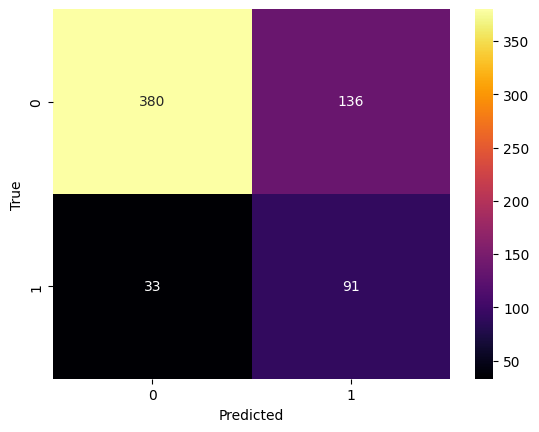

In [ ]:
# Plotting the Confusion Matrix for the model.

sns.heatmap(confusion_matrix(Test_df['DR'],test_Predictions_Bin,), annot = True, cmap = 'inferno', fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

### 11(1) Inception V3 Model and its training

In [ ]:
!mkdir InceptionV3

mkdir: cannot create directory ‘InceptionV3’: File exists


In [ ]:
filepath = "/content/drive/MyDrive/Models/InceptionV3/-{epoch:02d}-{recall:.02f}.h5"         # Getting the epoch and recall as filename for saving model as a file

In [ ]:
inceptionv3 = keras.applications.inception_v3.InceptionV3(
    include_top = False,
    weights = 'imagenet',
    input_shape = (224,224,3),
)

In [ ]:
inceptionv3.trainable = False

In [ ]:
incv3_model = Sequential([
    inceptionv3,
    Flatten(),
    Dense(64, activation = 'relu'),
    Dense(1, activation = 'sigmoid')
])

In [ ]:
# Compile the model
incv3_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['Recall'])

In [ ]:
# Train the model
history = incv3_model.fit(train_Features, train_Targets, epochs = 50, batch_size = 32, callbacks = [checkpoints])

Epoch 1/50
40/40 [==============================] - ETA: 0s - loss: 2.0296 - recall: 0.6732
Epoch 1: recall did not improve from 0.77559
40/40 [==============================] - 8s 71ms/step - loss: 2.0296 - recall: 0.6732
Epoch 2/50
40/40 [==============================] - ETA: 0s - loss: 0.2924 - recall: 0.8661
Epoch 2: recall improved from 0.77559 to 0.86614, saving model to /content/drive/MyDrive/Models/Sequential/-02-0.87.h5
40/40 [==============================] - 4s 90ms/step - loss: 0.2924 - recall: 0.8661
Epoch 3/50
40/40 [==============================] - ETA: 0s - loss: 0.1560 - recall: 0.9154
Epoch 3: recall improved from 0.86614 to 0.91535, saving model to /content/drive/MyDrive/Models/Sequential/-03-0.92.h5
40/40 [==============================] - 4s 98ms/step - loss: 0.1560 - recall: 0.9154
Epoch 4/50
40/40 [==============================] - ETA: 0s - loss: 0.1466 - recall: 0.9291
Epoch 4: recall improved from 0.91535 to 0.92913, saving model to /content/drive/MyDrive/Mo

### 11(2) Evaluation of Inception V3 Model

In [ ]:
# Evaluate the model on the test set
test_loss, test_acc = incv3_model.evaluate(test_Array, Test_df['DR'])
print('Test Recall:', test_acc)

In [ ]:
test_Predictions = incv3_model.predict(test_Array)

In [ ]:
np.mean(test_Predictions)

In [ ]:
test_Predictions_Bin = []
for prediction in test_Predictions:
  test_Predictions_Bin.append(0) if prediction <= np.mean(test_Predictions) else test_Predictions_Bin.append(1)

In [ ]:
pd.DataFrame(test_Predictions_Bin).value_counts()

In [ ]:
Test_df['DR'].value_counts()

In [ ]:
sns.heatmap(confusion_matrix(test_Predictions_Bin, Test_df['DR']), annot = True, fmt = 'd')
plt.ylabel('Predicted')
plt.xlabel('True')
plt.show()

### 12. Testing the model by predicting on an image taken from the User

In [ ]:
# print("Please uploade your Fundus Image Below: ")
# uploaded = files.upload()

Please uploade your Fundus Image Below: 


Saving 5.png to 5.png


In [ ]:
# image_Path = ""
# filelist = os.listdir('/content/')
# for file in filelist:
#     if (file.endswith(".png")):
#         image_Path += file

In [ ]:
image_Path_1 = '/content/1.png'
image_Path_2 = '/content/5.png'

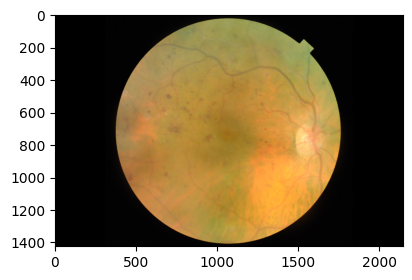

In [ ]:
plt.figure(figsize = (10, 3))
plt.imshow(cv2.cvtColor(cv2.imread(image_Path_2), cv2.COLOR_BGR2RGB))

In [ ]:
path_List_1 = [image_Path_2]

In [ ]:
seq_user_pred = seq_model.predict(img2Gray(path_List_1))[0][0]*100

1/1 [==============================] - 0s 25ms/step


In [ ]:
incv3_user_pred = incv3_model.predict(img2Gray(path_List_1))[0][0]*100

1/1 [==============================] - 0s 28ms/step


In [ ]:
print(f"Probability of Having Diabetic Retinopathy(Sequential model) : {seq_user_pred : .2f} %")

Probability of Having Diabetic Retinopathy(Sequential model) :  41.18 %


In [ ]:
print(f"Probability of Having Diabetic Retinopathy(InceptionV3 model) : {incv3_user_pred : .2f} %")

Probability of Having Diabetic Retinopathy(InceptionV3 model) :  80.41 %


# Demo

## Upload image 

In [ ]:
image_Path_1 = '/content/1.png'
# image_Path_1 = '/content/5.png'

## Display Image

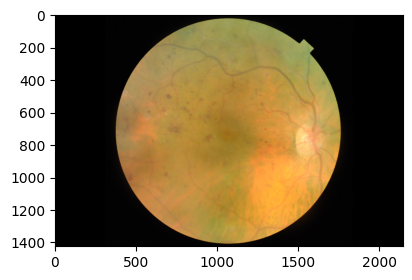

In [ ]:
plt.figure(figsize = (10, 3))
plt.imshow(cv2.cvtColor(cv2.imread(image_Path_1), cv2.COLOR_BGR2RGB))

## Probability of Diabetic

In [ ]:
seq_user_pred = seq_model.predict(img2Gray(path_List_1))[0][0]*100
print(f"Probability of Having Diabetic Retinopathy : {seq_user_pred : .2f} %")

1/1 [==============================] - 0s 32ms/step
Probability of Having Diabetic Retinopathy :  45.23 %
